# How to set up an analysis

H2Integrate is designed so that you can run a basic analysis or design problem without extensive Python experience.
The key inputs for the analysis are the configuration files, which are in YAML format.
This doc page will walk you through the steps to set up a basic analysis, focusing on the different types of configuration files and how use them.

## Top-level config file

The top-level config file is the main entry point for H2Integrate.
Its main purpose is to define the analysis type and the configuration files for the different components of the analysis.
Here is an example of a top-level config file:

```yaml
name: H2Integrate_config

system_summary: This reference hybrid plant is located in Minnesota and contains wind, solar, and battery storage technologies. The system is designed to produce hydrogen using an electrolyzer and also produce steel using a grid-connected plant.

driver_config: driver_config.yaml
technology_config: tech_config.yaml
plant_config: plant_config.yaml
```

The top-level config file contains the following keys:
- `name`: (optional) A name for the analysis. This is used to identify the analysis in the output files.
- `system_summary`: (optional) A summary of the analysis. This helpful for quickly describing the analysis for documentation purposes.

- `driver_config`: The path to the driver config file. This file defines the analysis type and the optimization settings.
- `technology_config`: The path to the technology config file. This file defines the technologies included in the analysis, their modeling parameters, and the performance, cost, and financial models used for each technology.
- `plant_config`: The path to the plant config file. This file defines the system configuration and how the technologies are connected together.

The goal of the organization of the top-level config file is that it is easy to swap out different configurations for the analysis without having to change the code.
For example, if you had different optimization problems, you could have different driver config files for each optimization problem and just change the `driver_config` key in the top-level config file to point to the new file.
This allows you to quickly test different configurations and see how they affect the results.

```{note}
The filepaths for the `plant_config`, `tech_config`, and `driver_config` files specified in the top-level config file can be specified as either:
1. Filepaths relative to the top-level config file; this is done in most examples
2. Filepaths relative to the current working directory; this is also done in most examples, which are intended to be run from the folder they're in.
3. Filepaths relative to the H2Integrate root directory; this works best for unique filenames.
4. Absolute filepaths.

More information about file handling in H2I can be found [here](https://h2integrate.readthedocs.io/en/latest/misc_resources/defining_filepaths.html)
```

## Driver config file

The driver config file defines the analysis type and the optimization settings.
If you are running a basic analysis and not an optimization, the driver config file is quite straightforward and might look like this:

```yaml
name: driver_config
description: This analysis runs a hybrid plant to match the first example in H2Integrate

general:
  folder_output: outputs
```

If you are running an optimization, the driver config file will contain additional keys to define the optimization settings, including design variables, constraints, and objective functions.
Further details of more complex instances of the driver config file can be found in more advanced examples as they are developed.

## Technology config file

The technology config file defines the technologies included in the analysis, their modeling parameters, and the performance, cost, and financial models used for each technology.
The yaml file is organized into sections for each technology included in the analysis under the `technologies` heading.
Here is an example of part of a technology config that is defining an energy system with only one technology, an electrolyzer:

```yaml
name: technology_config
description: This hybrid plant produces steel

technologies:
  electrolyzer:
    performance_model:
      model: eco_pem_electrolyzer_performance
    cost_model:
      model: eco_pem_electrolyzer_cost
    model_inputs:
      shared_parameters:
        location: onshore
        electrolyzer_capex: 2000 # $/kW overnight installed capital costs

      performance_parameters:
        sizing:
          resize_for_enduse: False
          size_for: BOL #'BOL' (generous) or 'EOL' (conservative)
          hydrogen_dmd:
        n_clusters: 13
        cluster_rating_MW: 40
        eol_eff_percent_loss: 13 #eol defined as x% change in efficiency from bol
        uptime_hours_until_eol: 77600 #number of 'on' hours until electrolyzer reaches eol
        include_degradation_penalty: True #include degradation
        turndown_ratio: 0.1 #turndown_ratio = minimum_cluster_power/cluster_rating_MW

      cost_parameters:
        cost_model: singlitico2021

      financial_parameters:
        capital_items:
          depr_period: 7
          replacement_cost_percent: 0.15 # percent of capex - H2A default case
```

Here, we have defined a electrolyzer model that uses the built-in `eco_pem_electrolyzer_performance` and `eco_pem_electrolyzer_cost` models.
The `performance_model` and `cost_model` keys define the models used for the performance and cost calculations, respectively.
The `model_inputs` key contains the inputs for the models, which are organized into sections for shared parameters, performance parameters, cost parameters, and financial parameters.
Here, we do not define the `financial_model` key, so the default financial model from ProFAST is used.

The `shared_parameters` section contains parameters that are common to all models, such as the rating and location of the technology.
These values are defined once in the `shared_parameters` section and are used by all models that reference them.
The `performance_parameters` section contains parameters that are specific to the performance model, such as the sizing and efficiency of the technology.
The `cost_parameters` section contains parameters that are specific to the cost model, such as the capital costs and replacement costs.
The `financial_parameters` section contains parameters that are specific to the financial model, such as the replacement costs and financing terms.

```{note}
There are no default values for the parameters in the technology config file.
You must define all the parameters for the models you are using in the analysis.
```

Based on which models you choose to use, the inputs will vary.
Each model has its own set of inputs, which are defined in the source code for the model.
Because there are no default values for the parameters, we suggest you look at an existing example that uses the model you are interested in to see what inputs are required or look at the source code for the model.
The different models are defined in the `supported_models.py` file in the `h2integrate` package.

## Plant config file

The plant config file defines the system configuration, any parameters that might be shared across technologies, and how the technologies are connected together.

Here is a snippet of an example plant config file:

```yaml
name: plant_config
description: This plant is located in MN, USA

site:
  latitude: 47.5233
  longitude: -92.5366
  elevation_m: 439.0

# array of arrays containing left-to-right technology
# interconnections; can support bidirectional connections
# with the reverse definition.
# this will naturally grow as we mature the interconnected tech
technology_interconnections: [
  ["wind", "electrolyzer", "electricity", "cable"],
  ["electrolyzer", "h2_storage", "efficiency"],
  ["electrolyzer", "h2_storage", "hydrogen", "pipe"],
  ["finance_subgroup_1", "steel", "LCOH"],
  ["wind", "steel", "electricity", "cable"],
  # etc
]

plant:
  plant_life: 30
  grid_connection: False # option, can be turned on or off
  ppa_price: 0.025 # $/kWh
  hybrid_electricity_estimated_cf: 0.492
  

finance_parameters:
  finance_model: "ProFastComp"
  model_inputs:
    params:
      analysis_start_year: 2032
      installation_time: 36 # months
  cost_adjustment_parameters:
    target_dollar_year: 2022
    cost_year_adjustment_inflation: 0.025 # used to adjust modeled costs to target_dollar_year
  inflation_rate: 0.0 # 0 for nominal analysis
...
```

The `site` section contains the site parameters, such as the latitude, longitude, elevation, and time zone.
The `plant` section contains the plant parameters, such as the plant life, grid connection, PPA price, and installation time.
The `finance_parameters` section contains the financial parameters used across the plant, such as the inflation rates, financing terms, and other financial parameters.

The `technology_interconnections` section contains the interconnections between the technologies in the system and is the most complex part of the plant config file.
The interconnections are defined as an list of lists, where each sub-list defines a connection between two technologies.
The first entry in the list is the technology that is providing the input to the next technology in the list.
If the list is length 4, then the third entry in the list is what's passing passed via a transporter of the type defined in the fourth entry.
If the list is length 3, then the third entry in the list is what is connected directly between the technologies.

```{note}
For more information on how to define and interpret technology interconnections, see the {ref}`connecting_technologies` page.
```

## Running the analysis

Once you have the config files defined, you can run the analysis using a simple Python script that inputs the top-level config yaml.
Here, we will show a script that runs one of the example analyses included in the H2Integrate package.

In [1]:
from h2integrate.core.h2integrate_model import H2IntegrateModel
import os


# Change the current working directory
os.chdir("../../examples/08_wind_electrolyzer/")

# Create a H2Integrate model
h2i_model = H2IntegrateModel("wind_plant_electrolyzer.yaml")

# Run the model
h2i_model.run()

# h2i_model.post_process()

# Print the total hydrogen produced by the electrolyzer in kg/year
total_hydrogen = h2i_model.model.get_val("electrolyzer.total_hydrogen_produced", units="kg/year")[0]
print(f"Total hydrogen produced by the electrolyzer: {total_hydrogen:.2f} kg/year")

c:\Users\jjasa\Documents\git\H2Integrate\docs\user_guide\log\hybrid_systems_2025-09-17T22.35.53.165779.log
XDSM diagram written to connections_xdsm.pdf
Total hydrogen produced by the electrolyzer: 51724444.41 kg/year


This will run the analysis defined in the config files and generate the output files in the through the `post_process` method.

## Modifying and rerunning the analysis

Once the configs are loaded into H2I, they are stored in the `H2IntegrateModel` instance as dictionaries, so you can modify them and rerun the analysis without having to reload the config files.
Here is an example of how to modify the config files and rerun the analysis:

In [2]:
# Access the configuration dictionaries
tech_config = h2i_model.technology_config

# Modify a parameter in the technology config
tech_config["technologies"]["electrolyzer"]["model_inputs"]["performance_parameters"][
    "n_clusters"
] = 15

# Rerun the model with the updated configurations
h2i_model.run()

# Post-process the results
# h2i_model.post_process()

# Print the total hydrogen produced by the electrolyzer in kg/year
total_hydrogen = h2i_model.model.get_val("electrolyzer.total_hydrogen_produced", units="kg/year")[0]
print(f"Total hydrogen produced by the electrolyzer: {total_hydrogen:.2f} kg/year")

Total hydrogen produced by the electrolyzer: 56631148.67 kg/year


This is especially useful when you want to run an H2I model as a script and modify parameters dynamically without changing the original YAML configuration file.
If you want to do a simple parameter sweep, you can wrap this in a loop and modify the parameters as needed.

In the example below, we modify the electrolyzer end-of-life efficiency drop and plot the impact on the LCOH.

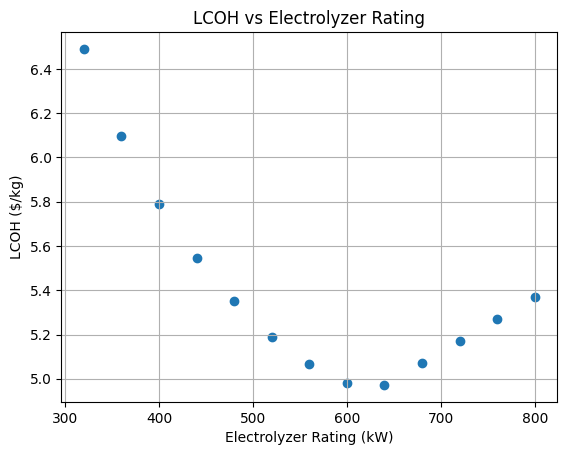

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Get the electrolyzer cluster rated capacity
cluster_size_mw = int(
    tech_config["technologies"]["electrolyzer"]["model_inputs"]["performance_parameters"][
        "cluster_rating_MW"
    ]
)

# Define the range for electrolyzer rating
ratings = np.arange(320, 840, cluster_size_mw)

# Initialize arrays to store results
lcoh_results = []

for rating in ratings:
    # Calculate the number of clusters from the rating
    n_clusters = int(rating / cluster_size_mw)

    # Update the number of clusters
    tech_config["technologies"]["electrolyzer"]["model_inputs"]["performance_parameters"][
        "n_clusters"
    ] = n_clusters

    # Rerun the model with the updated configurations
    h2i_model.run()

    # Get the LCOH value
    lcoh = h2i_model.model.get_val("finance_subgroup_default.LCOH", units="USD/kg")[0]

    # Store the results
    lcoh_results.append(lcoh)

# Create a scatter plot
plt.scatter(ratings, lcoh_results)
plt.xlabel("Electrolyzer Rating (kW)")
plt.ylabel("LCOH ($/kg)")
plt.title("LCOH vs Electrolyzer Rating")
plt.grid(True)
plt.show()